In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map, MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
#from my_dataset_maps_20 import MapDatasetNuisance
#from  my_fit_20 import Fit


from scipy.optimize import curve_fit

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : cvuQDGwK 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : JdQ6nCB1
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

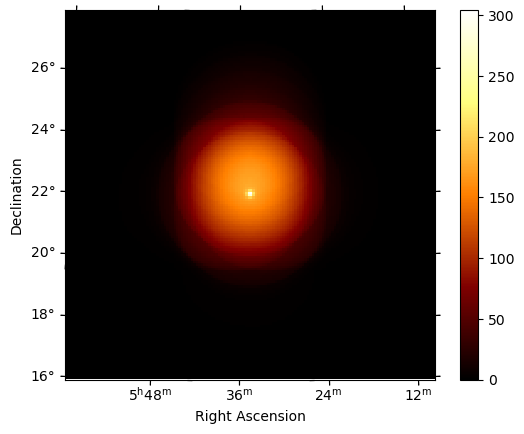

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models_input = Models(source_model)
models = Models(source_model)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

asimov = True
if asimov:
    dataset_standard.counts = dataset_standard.npred()
    
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(    "spatial binsize = ",    binsize)

print(dataset_standard)
fit = Fit()
result = fit.run(dataset_standard)

In [4]:
'''shift = 0.8
dataset_shifted = MapDataset.read(f"stacked_shifted{shift}.fits.gz")

models_shifted = Models(source_model)
bkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted.name)
bkg_model_shifted.parameters['tilt'].frozen  = False
models_shifted.append(bkg_model_shifted)
dataset_shifted.models = models_shifted'''

'shift = 0.8\ndataset_shifted = MapDataset.read(f"stacked_shifted{shift}.fits.gz")\n\nmodels_shifted = Models(source_model)\nbkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted.name)\nbkg_model_shifted.parameters[\'tilt\'].frozen  = False\nmodels_shifted.append(bkg_model_shifted)\ndataset_shifted.models = models_shifted'

How does the model get evaluated at a specific energy? Or would it be easier to change the IRF?

### Option 1: evaluate at a different energy


 - `MapDataset` has an evaluator: `gammapy.datasets.evaluator.MapEvaluator`
 - Evaluates the model on the exposures geometry "True energy map geometry"
 - order: self.compute_flux, self.apply_exposure, self.apply_edisp, self.apply_psf
 - First step: 
        def compute_flux(self, *arg):
        """Compute flux"""
        return self.model.integrate_geom(self.geom, self.gti)


In [5]:
#copy the standard dataset 
dataset_shifted_1 = dataset_standard.copy()
models_shifted = Models(source_model)
bkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted_1.name)
bkg_model_shifted.parameters['tilt'].frozen  = False
models_shifted.append(bkg_model_shifted)
dataset_shifted_1.models = models_shifted




Text(0, 0.5, 'Predicted Flux [1 / (cm2 s)]')

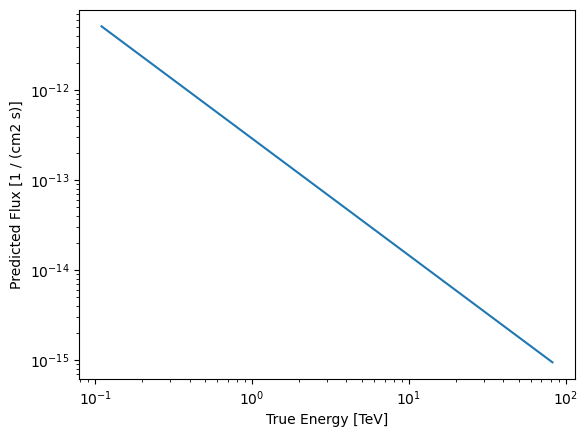

In [31]:
# Computing the correct flux with the original exposure
true_energy_geom = dataset_shifted_1.exposure.geom
compute_flux = dataset_shifted_1.models['Source'].integrate_geom(true_energy_geom)
compute_flux_e = compute_flux.data.sum(axis=2).sum(axis=1)
plt.plot(true_energy_geom.axes[0].center.value, compute_flux_e)
plt.loglog()
plt.xlabel("True Energy [TeV]")
plt.ylabel(f"Predicted Flux [{compute_flux.unit}]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


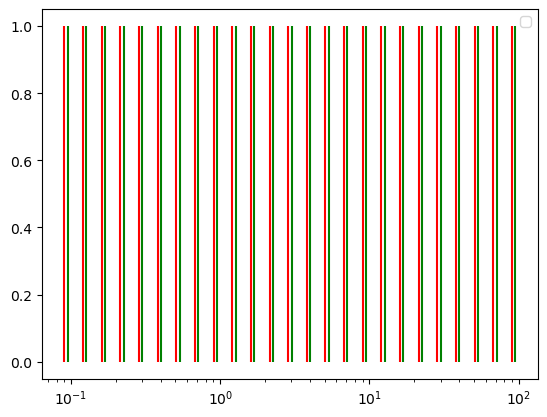

In [33]:
# shfiting the energy axis and creating a new geom out of it
shift = 0.95
shifted_eaxis = MapAxis(nodes = true_energy_geom.axes[0].edges * shift,
                        interp='log', 
                        name=true_energy_geom.axes[0].name, 
                        node_type='edges')
true_energy_geom_shifted = true_energy_geom.copy().to_image()
true_energy_geom_shifted = true_energy_geom_shifted.to_cube([shifted_eaxis])


fig = plt.figure()
for e in true_energy_geom_shifted.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in true_energy_geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()

Text(0, 0.5, 'Predicted Flux [1 / (cm2 s)]')

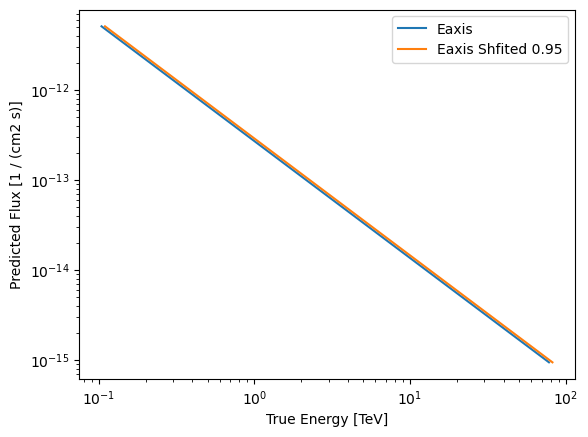

In [34]:
# compute the flux now with this shifted geom
compute_flux_shifted = dataset_shifted_1.models['Source'].integrate_geom(true_energy_geom_shifted)
compute_flux_e_shifted = compute_flux.data.sum(axis=2).sum(axis=1)
plt.plot(true_energy_geom_shifted.axes[0].center.value, compute_flux_e_shifted,
        label = "Eaxis")
plt.plot(true_energy_geom.axes[0].center.value, compute_flux_e,
        label = f"Eaxis Shfited {shift}")

plt.loglog(); plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel(f"Predicted Flux [{compute_flux.unit}]")

In [9]:
'''geom_edisp_shifted = dataset_standard.edisp.edisp_map.geom.to_image()
geom_edisp_shifted = geom_edisp_shifted.to_cube([shifted_eaxis.copy(name = 'energy'),
                                                 dataset_standard.edisp.edisp_map.geom.axes['energy_true'],
                           ])
edisp_shifted = Map.from_geom(geom_edisp_shifted,
                             data = dataset_standard.edisp.edisp_map.data)
edisp_shifted'''

"geom_edisp_shifted = dataset_standard.edisp.edisp_map.geom.to_image()\ngeom_edisp_shifted = geom_edisp_shifted.to_cube([shifted_eaxis.copy(name = 'energy'),\n                                                 dataset_standard.edisp.edisp_map.geom.axes['energy_true'],\n                           ])\nedisp_shifted = Map.from_geom(geom_edisp_shifted,\n                             data = dataset_standard.edisp.edisp_map.data)\nedisp_shifted"

[]

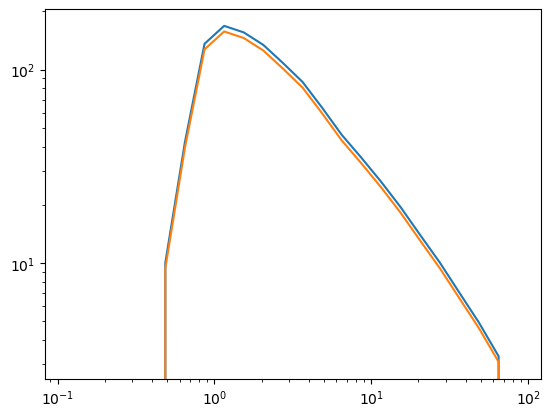

In [10]:



ex_shifted = Map.from_geom(true_energy_geom_shifted,
                             data = dataset_shifted_1.exposure.data,
                          unit = dataset_shifted_1.exposure.unit)
ex_orgi = dataset_shifted_1.exposure.copy()

dataset_shifted_1.exposure = ex_shifted

npred_signal_shifted  = dataset_shifted_1.npred_signal()
npred_signal_shifted_e = npred_signal_shifted.data.sum(axis=2).sum(axis=1)


npred_signal  = dataset_standard.npred_signal()
npred_signal_e = npred_signal.data.sum(axis=2).sum(axis=1)

plt.plot(npred_signal_shifted.geom.axes[0].center.value, npred_signal_shifted_e)
plt.plot(npred_signal.geom.axes[0].center.value, npred_signal_e)

plt.loglog()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


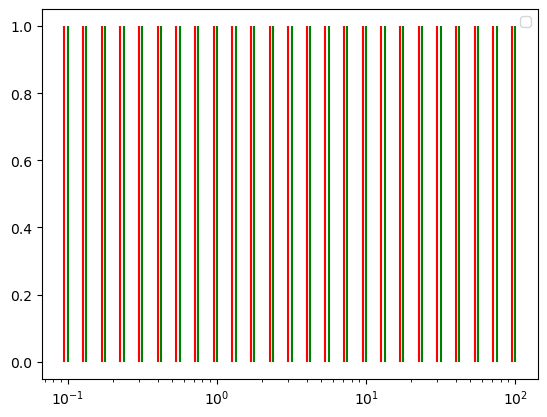

In [11]:
fig = plt.figure()
for e in dataset_shifted_1.exposure.geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in dataset_standard.exposure.geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


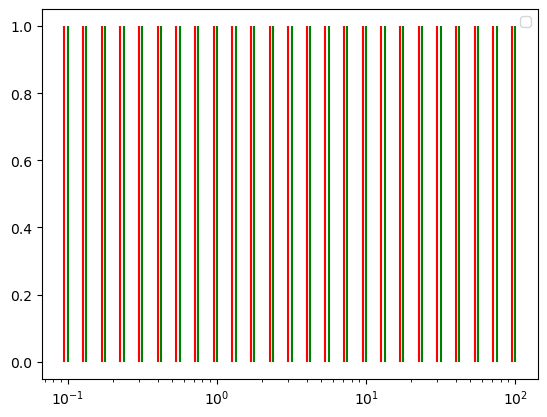

In [12]:
fig = plt.figure()
for e in dataset_shifted_1.exposure.geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in dataset_standard.exposure.geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()

### I think this would work. However, one would need to create a new geometry in every fitting iteration step. Timeconsuming


## Opption 2: Change the IRF

      """Convolve map data with energy dispersion.

        Parameters
        ----------
        npred : `~gammapy.maps.Map`
            Predicted counts in true energy bins

        Returns
        -------
        npred_reco : `~gammapy.maps.Map`
            Predicted counts in reco energy bins
        """
        return npred.apply_edisp(self.edisp)
        
        
    def apply_edisp(self, edisp):
        """Apply energy dispersion to map. Requires energy axis.

        Parameters
        ----------
        edisp : `gammapy.irf.EDispKernel`
            Energy dispersion matrix

        Returns
        -------
        map : `WcsNDMap`
            Map with energy dispersion applied.
        """
        # TODO: either use sparse matrix mutiplication or something like edisp.is_diagonal
        if edisp is not None:
            loc = self.geom.axes.index("energy_true")
            data = np.rollaxis(self.data, loc, len(self.data.shape))
            data = np.dot(data, edisp.pdf_matrix)
            data = np.rollaxis(data, -1, loc)
            energy_axis = edisp.axes["energy"].copy(name="energy")
        else:
            data = self.data
            energy_axis = self.geom.axes["energy_true"].copy(name="energy")

        geom = self.geom.to_image().to_cube(axes=[energy_axis])
        return self._init_copy(geom=geom, data=data)

In [13]:
dataset_shifted_2 = dataset_standard.copy()
models_shifted = Models(source_model)
bkg_model_shifted = FoVBackgroundModel(dataset_name=dataset_shifted_2.name)
bkg_model_shifted.parameters['tilt'].frozen  = False
models_shifted.append(bkg_model_shifted)
dataset_shifted_2.models = models_shifted

In [14]:
#Create the npred with energy_true:
evaluator_standard = dataset_standard.evaluators[dataset_standard.models[0].name]
print(evaluator_standard.edisp)
flux = evaluator_standard.compute_flux()
npred = (flux.quantity * evaluator_standard.exposure.quantity).to_value("")
npred = Map.from_geom(evaluator_standard.geom, data=npred, unit="")
print(npred)

EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (24, 24)
  ndim  : 2
  unit  : 
  dtype : >f4

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (23, 23, 24)
	ndim  : 3
	unit  : 
	dtype : float64



In [15]:
def apply_edisp(npred, edisp):
    """Apply energy dispersion to map. Requires energy axis.

    Parameters
    ----------
    edisp : `gammapy.irf.EDispKernel`
        Energy dispersion matrix

    Returns
    -------
    map : `WcsNDMap`
        Map with energy dispersion applied.
    """
    # TODO: either use sparse matrix mutiplication or something like edisp.is_diagonal
    if edisp is not None:
        loc = npred.geom.axes.index("energy_true")
        data = np.rollaxis(npred.data, loc, len(npred.data.shape))
        data = np.dot(data, edisp.pdf_matrix)
        data = np.rollaxis(data, -1, loc)
        energy_axis = edisp.axes["energy"].copy(name="energy")
    else:
        data = npred.data
        energy_axis = self.geom.axes["energy_true"].copy(name="energy")

    geom = npred.geom.to_image().to_cube(axes=[energy_axis])
    return npred._init_copy(geom=geom, data=data)

[]

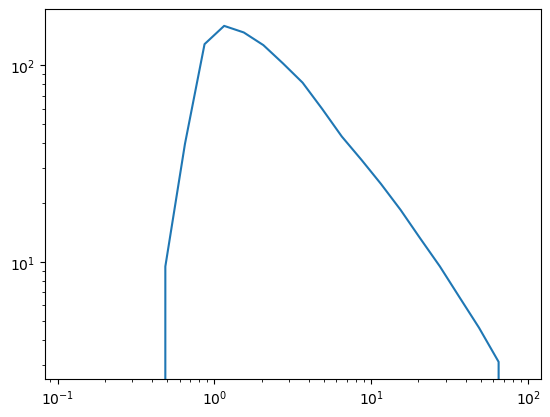

In [16]:
npred_edisp = apply_edisp(npred, evaluator_standard.edisp)
plt.plot(npred_edisp.geom.axes[0].center, npred_edisp.data.sum(axis = 2).sum(axis=1))
plt.loglog()

In [30]:
edisp_shifted = dataset_shifted_2.edisp.resample_energy_axis(shifted_eaxis)

dataset_shifted_edisp = dataset_shifted_2.copy()
dataset_shifted_edisp.models = dataset_shifted_2.models.copy()
dataset_shifted_edisp.edisp = edisp_shifted

dataset_shifted_edisp.npred_signal() # neeeded to create the evaluator

evaluator_shifted = dataset_shifted_edisp.evaluators[dataset_shifted_edisp.models[0].name]
evaluator_shifted.edisp = dataset_shifted_edisp.edisp.get_edisp_kernel(
                position=evaluator_shifted.model.position, energy_axis=eaxis
            )

print(dataset_shifted_edisp.edisp)
print(evaluator_shifted.edisp)
print(dataset_shifted_edisp.edisp)

NameError: name 'eaxis' is not defined

[]

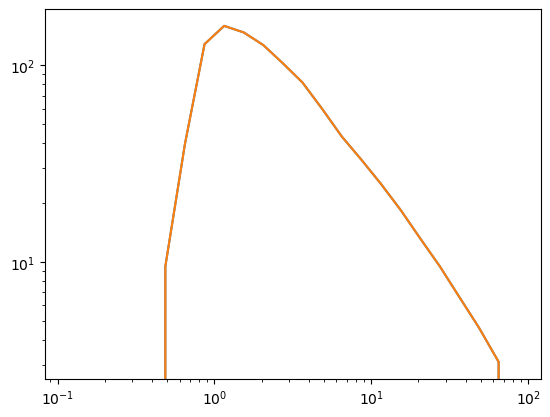

In [18]:
npred_edisp_shifted = apply_edisp(npred, evaluator_shifted.edisp)
plt.plot(npred_edisp.geom.axes[0].center, npred_edisp.data.sum(axis = 2).sum(axis=1))
plt.plot(npred_edisp_shifted.geom.axes[0].center, npred_edisp_shifted.data.sum(axis = 2).sum(axis=1))

plt.loglog()

In [19]:
edisp_shifted.edisp_map.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'energy_true']
	shape      : (60, 60, 24, 24)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 12.0 deg x 12.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'energy')

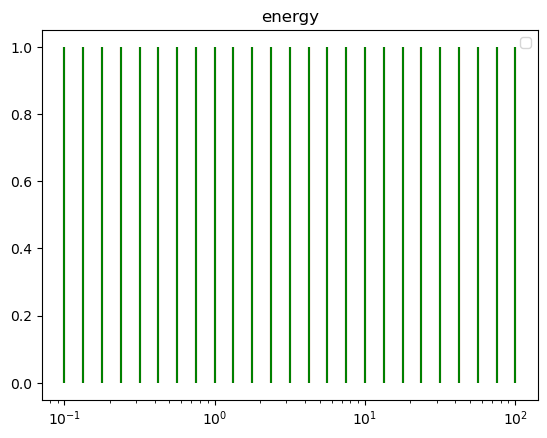

In [20]:
fig = plt.figure()
for e in edisp_shifted.edisp_map.geom.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in evaluator_shifted.edisp.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()
plt.title(evaluator_shifted.edisp.axes[1].name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'energy')

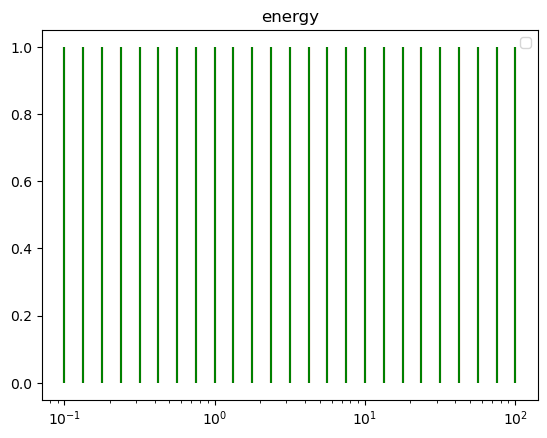

In [21]:
fig = plt.figure()
for e in evaluator_standard.edisp.axes[1].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in evaluator_shifted.edisp.axes[1].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()
plt.title(evaluator_shifted.edisp.axes[1].name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'energy_true')

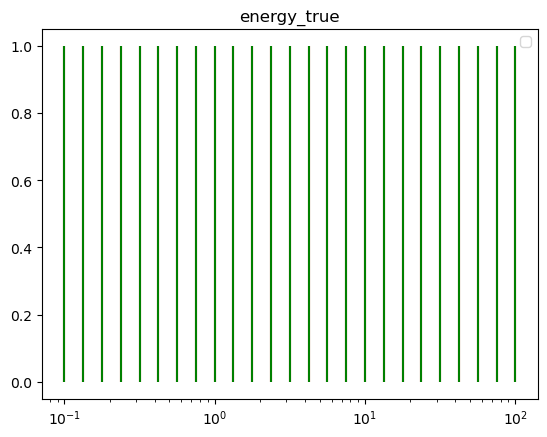

In [22]:
fig = plt.figure()
for e in evaluator_standard.edisp.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'red', )
for e in evaluator_shifted.edisp.axes[0].edges.value:
    plt.vlines(e, 0,1, color = 'green')    
plt.xscale('log')
plt.legend()
plt.title(evaluator_shifted.edisp.axes[0].name)

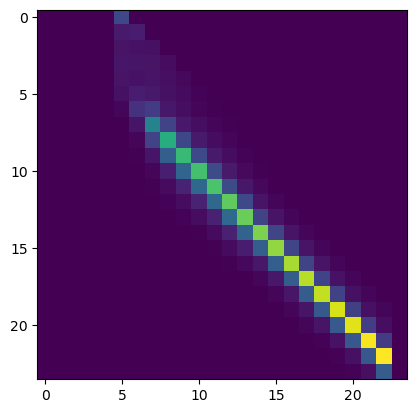

In [23]:
plt.imshow(evaluator_standard.edisp.pdf_matrix)

In [24]:
dataset_shifted.edisp

NameError: name 'dataset_shifted' is not defined

In [ ]:
dataset_shifted.edisp.peek()

In [ ]:
class MapEvaluator:
    '''
    Parameters
    
    model : `~gammapy.modeling.models.SkyModel`
        Sky model
    exposure : `~gammapy.maps.Map`
        Exposure map
    psf : `~gammapy.irf.PSFKernel`
        PSF kernel
    edisp : `~gammapy.irf.EDispKernel`
        Energy dispersion
    mask : `~gammapy.maps.Map`
        Mask to apply to the likelihood for fitting.
    gti : `~gammapy.data.GTI`
        GTI of the observation or union of GTI if it is a stacked observation
    evaluation_mode : {"local", "global"}
        Model evaluation mode.
        The "local" mode evaluates the model components on smaller grids to save computation time.
        This mode is recommended for local optimization algorithms.
        The "global" evaluation mode evaluates the model components on the full map.
        This mode is recommended for global optimization algorithms.
    use_cache : bool
        Use npred caching.
    '''
    def __init__(
        self,
        model,
        exposure=None,
        psf=None,
        edisp=None,
        gti=None,
        mask=None,
        evaluation_mode="local",
        use_cache=True,
    ):

        self.model = model
        self.exposure = exposure
        self.psf = psf
        self.edisp = edisp
        self.mask = mask
        self.gti = gti
        self.use_cache = use_cache
        self._init_position = None
        self.contributes = True
        self.psf_containment = None

        if evaluation_mode not in {"local", "global"}:
            raise ValueError(f"Invalid evaluation_mode: {evaluation_mode!r}")

        self.evaluation_mode = evaluation_mode

        # TODO: this is preliminary solution until we have further unified the model handling
        if (
            isinstance(self.model, TemplateNPredModel)
            or self.model.spatial_model is None
            or self.model.evaluation_radius is None
        ):
            self.evaluation_mode = "global"

        # define cached computations
        self._cached_parameter_values = None
        self._cached_parameter_values_previous = None
        self._cached_parameter_values_spatial = None
        self._cached_position = (0, 0)
        self._computation_cache = None
        self._neval = 0  # for debugging
        self._renorm = 1
        self._spatial_oversampling_factor = 1
        if self.exposure is not None:
            if not self.geom.is_region or self.geom.region is not None:
                self.update_spatial_oversampling_factor(self.geom)

    @property
    def geom(self):
        """True energy map geometry (`~gammapy.maps.Geom`)"""
        return self.exposure.geom

   
    @property
    def cutout_width(self):
        """Cutout width for the model component"""
        return self.psf_width + 2 * (self.model.evaluation_radius + CUTOUT_MARGIN)

    def update(self, exposure, psf, edisp, geom, mask):
        """Update MapEvaluator, based on the current position of the model component.

        Parameters
        ----------
        exposure : `~gammapy.maps.Map`
            Exposure map.
        psf : `gammapy.irf.PSFMap`
            PSF map.
        edisp : `gammapy.irf.EDispMap`
            Edisp map.
        geom : `WcsGeom`
            Counts geom
        mask : `~gammapy.maps.Map`
            Mask to apply to the likelihood for fitting.
        """
        # TODO: simplify and clean up
        log.debug("Updating model evaluator")

        # lookup edisp
        if edisp:
            energy_axis = geom.axes["energy"]
            self.edisp = edisp.get_edisp_kernel(
                position=self.model.position, energy_axis=energy_axis
            )

        # lookup psf
        if psf and self.model.spatial_model:
            energy_name = psf.energy_name
            if energy_name == "energy":
                geom_psf = geom
            else:
                geom_psf = exposure.geom

            if self.use_psf_containment(geom=geom_psf):
                energy_values = geom_psf.axes[energy_name].center.reshape((-1, 1, 1))
                kwargs = {energy_name: energy_values, "rad": geom.region.radius}
                self.psf_containment = psf.containment(**kwargs)
            else:
                if geom_psf.is_region or geom_psf.is_hpx:
                    geom_psf = geom_psf.to_wcs_geom()

                self.psf = psf.get_psf_kernel(
                    position=self.model.position,
                    geom=geom_psf,
                    containment=PSF_CONTAINMENT,
                )

        if self.evaluation_mode == "local":
            self.contributes = self.model.contributes(mask=mask, margin=self.psf_width)

            if self.contributes:
                self.exposure = exposure.cutout(
                    position=self.model.position, width=self.cutout_width, odd_npix=True
                )
        else:
            self.exposure = exposure

        if self.contributes:
            if not self.geom.is_region or self.geom.region is not None:
                self.update_spatial_oversampling_factor(self.geom)

        self.reset_cache_properties()
        self._computation_cache = None
        self._cached_parameter_previous = None

    def compute_dnde(self):
        """Compute model differential flux at map pixel centers.

        Returns
        -------
        model_map : `~gammapy.maps.Map`
            Sky cube with data filled with evaluated model values.
            Units: ``cm-2 s-1 TeV-1 deg-2``
        """
        return self.model.evaluate_geom(self.geom, self.gti)

    def compute_flux(self, *arg):
        """Compute flux"""
        return self.model.integrate_geom(self.geom, self.gti)

    def compute_flux_psf_convolved(self, *arg):
        """Compute psf convolved and temporal model corrected flux."""
        value = self.compute_flux_spectral()

        if self.model.spatial_model:
            if self.psf_containment is not None:
                value = value * self.psf_containment
            else:
                value = value * self.compute_flux_spatial()

        if self.model.temporal_model:
            value *= self.compute_temporal_norm()

        return Map.from_geom(geom=self.geom, data=value.value, unit=value.unit)

   
    def compute_flux_spectral(self):
        """Compute spectral flux"""
        energy = self.geom.axes["energy_true"].edges
        value = self.model.spectral_model.integral(
            energy[:-1],
            energy[1:],
        )
        if self.geom.is_hpx:
            return value.reshape((-1, 1))
        else:
            return value.reshape((-1, 1, 1))

   

    def apply_edisp(self, npred):
        """Convolve map data with energy dispersion.

        Parameters
        ----------
        npred : `~gammapy.maps.Map`
            Predicted counts in true energy bins

        Returns
        -------
        npred_reco : `~gammapy.maps.Map`
            Predicted counts in reco energy bins
        """
        return npred.apply_edisp(self.edisp)

    def _compute_npred(self):
        """Compute npred"""
        if isinstance(self.model, TemplateNPredModel):
            npred = self.model.evaluate()
        else:
            if not self.parameter_norm_only_changed:
                for method in self.methods_sequence:
                    values = method(self._computation_cache)
                    self._computation_cache = values
                npred = self._computation_cache
            else:
                npred = self._computation_cache * self.renorm()
        return npred

    def compute_npred(self):
        """Evaluate model predicted counts.

        Returns
        -------
        npred : `~gammapy.maps.Map`
            Predicted counts on the map (in reco energy bins)
        """
        if self.parameters_changed or not self.use_cache:
            del self._compute_npred

        return self._compute_npred



In [ ]:
dataset_shifted.evaluators['Source'].peek()

In [ ]:
print(gammapy)